In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!cp "/content/drive/My Drive/datasets/super-res-large.zip" "dataset.zip"
!unzip -q  dataset.zip 

replace dataset-lg/test/hr/dt_val_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [61]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model

In [62]:
db_dir = "dataset-lg"

In [63]:
def get_train_data():
    X = []
    Y = []
    for x in os.listdir(db_dir + "/train/lr"):
        img_x = cv2.imread(db_dir + "/train/lr/" + x)
        X.append(img_x)
    
    X = np.array(X) / 255
    
    for y in os.listdir(db_dir + "/train/hr"):
        img_y = cv2.imread(db_dir + "/train/hr/" + y)
        Y.append(img_y)
  
    Y = np.array(Y) / 255 
    
    return X,Y


train_lr, train_hr = get_train_data()

In [64]:
def get_test_data():
    X = []
    Y = []

    for x in os.listdir(db_dir + "/test/lr"):
        img_x = cv2.imread(db_dir + "/test/lr/" + x)
        X.append(img_x)

    X = np.array(X) / 255

    for y in os.listdir(db_dir + "/test/hr"):
        
        img_y = cv2.imread(db_dir + "/test/hr/" + y)
        Y.append(img_y)
    Y = np.array(Y) / 255
    
    return X,Y


test_lr, test_hr = get_test_data()

## Generator

In [65]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

## Generator model

In [66]:
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=lr_ip, outputs=op)

In [67]:
print("train_shape ", train_lr.shape, " test_shape ", test_lr.shape )

num_res_block = 16
hr_shape = (train_hr.shape[1], train_hr.shape[2], train_hr.shape[3])
lr_shape = (train_lr.shape[1], train_lr.shape[2], train_lr.shape[3])

Conv2D = layers.Conv2D
BatchNormalization = layers.BatchNormalization
PReLU = layers.PReLU
UpSampling2D = layers.UpSampling2D
Dense = layers.Dense
add = layers.add
LeakyReLU = layers.LeakyReLU
Input = layers.Input
Flatten = layers.Flatten


lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

train_shape  (2500, 25, 25, 3)  test_shape  (500, 25, 25, 3)


## Discriminator

In [68]:


def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    
    return disc_model
    

## Discriminator model

In [69]:
def create_disc(disc_ip):

    d0 = Input(shape=hr_shape)
    df = 64
    
    d1 = discriminator_block(d0, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(d0, validity)
    


## VGG19

In [70]:
from keras.applications import VGG19

def build_vgg():
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]

    img = Input(shape=hr_shape)

    img_features = vgg(img)

    return Model(img, img_features)



## Combined Model

In [71]:


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [72]:

generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False

vgg.compile(loss='mse',
        optimizer="adam",
        metrics=['accuracy'])

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam")



In [73]:
# generator.summary()
# discriminator.summary()
# discriminator.trainable = False
gan_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 25, 25, 3)    0                                            
__________________________________________________________________________________________________
model_5 (Model)                 (None, 100, 100, 3)  2044291     input_6[0][0]                    
__________________________________________________________________________________________________
model_6 (Model)                 (None, 1)            30384961    model_5[1][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 25, 25, 256)  143667240   model_5[1][0]                    
Total params: 176,096,492
Trainable params: 2,040,067
Non-trainable params: 174,056,425
____

In [74]:
batch_size = 50
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])

train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)


In [ ]:
epoch_start = 300
epoch_end = 320

generator.load_weights("drive/My Drive/models/sr/gen/e_"+ str(epoch_start) +".h5")
discriminator.load_weights("drive/My Drive/models/sr/disc/e_"+ str(epoch_start) +".h5")

for e in range(epoch_start, epoch_end):
    
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        
        gen_imgs = generator.predict_on_batch(lr_imgs)

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        image_features = vgg.predict(hr_imgs)

        g_loss,_,_ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)
    if (e+1) % 10 == 0:
        discriminator.save_weights("drive/My Drive/models/sr/disc/e_"+ str(e+1) + ".h5")
        generator.save_weights("drive/My Drive/models/sr/gen/e_"+ str(e+1) + ".h5")
       


In [93]:
generator.load_weights("drive/My Drive/models/sr/gen/e_300.h5")
discriminator.load_weights("drive/My Drive/models/sr/disc/e_300.h5")

In [96]:
res = gan_model.evaluate([test_lr, test_hr], [np.ones((500,1)), vgg.predict(test_hr)])
print(res)

500/500 [==============================] - 5s 10ms/step
[7.515039932250977, 3.0002591609954834, 7.534689426422119]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


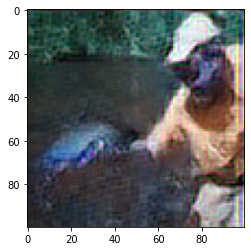

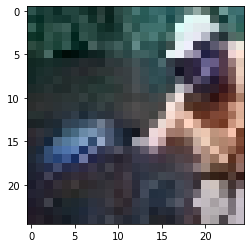

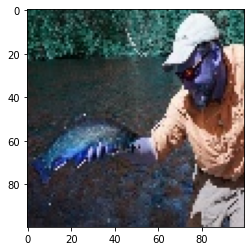

In [98]:
pred = generator.predict_on_batch(train_lr_batches[7])
plt.imshow(pred[1])
plt.show()


plt.imshow((train_lr_batches[7][1]*255).astype(int))
plt.show()

plt.imshow( (train_hr_batches[7][1]*255).astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


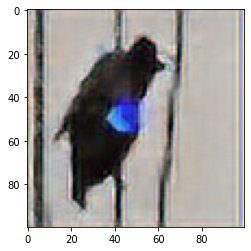

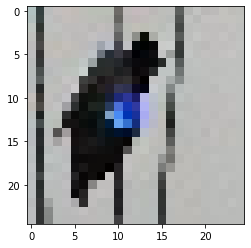

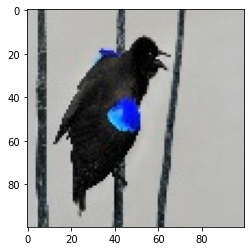

True

In [104]:
test_pred = generator.predict_on_batch(test_lr[:10])

plt.imshow(test_pred[8])
plt.show()
cv2.imwrite("pred.jpg",test_pred[8]*255)


plt.imshow(test_lr[8])
plt.show()
cv2.imwrite("lr.jpg",test_lr[8]*255)

plt.imshow( test_hr[8])
plt.show()
cv2.imwrite("hr.jpg", test_hr[8]*255)
